# Lab 4 Report: 
## Surpass Human Performance in Fashion MNIST Classificaion

### Name: William Y. Feng

In [101]:
import matplotlib.pyplot as plt

import torch
import numpy as np

## Prepare Data

In [103]:
# 10000 training features/targets where each feature is a greyscale image with shape (100, 100)
# ~20 seconds
data_dir = "./data/jets-100k-preprocessed"

raw_train_features = np.load(f"{data_dir}/jets-train-features.npy")
train_targets = np.load(f"{data_dir}/jets-train-targets.npy")

# 1000 testing features/targets 
raw_test_features = np.load(f"{data_dir}/jets-test-features.npy")
test_targets = np.load(f"{data_dir}/jets-test-targets.npy")

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", raw_train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", raw_test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (99500, 32, 32)
Training Targets Shape:  (99500,)
Testing Features Shape:  (500, 32, 32)
Testing Targets Shape:  (500,)


In [104]:
# Shuffle things around
import random

M_train = raw_train_features.shape[0]
train_indices = list(range(M_train))
random.shuffle(train_indices)

raw_train_features = raw_train_features[train_indices]
train_targets = train_targets[train_indices]


M_test = raw_test_features.shape[0]
test_indices = list(range(M_test))
random.shuffle(test_indices)

raw_test_features = raw_test_features[test_indices]
test_targets = test_targets[test_indices]

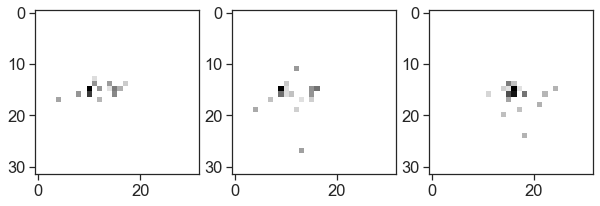

In [105]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(raw_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(raw_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(raw_train_features[2], cmap = 'Greys')

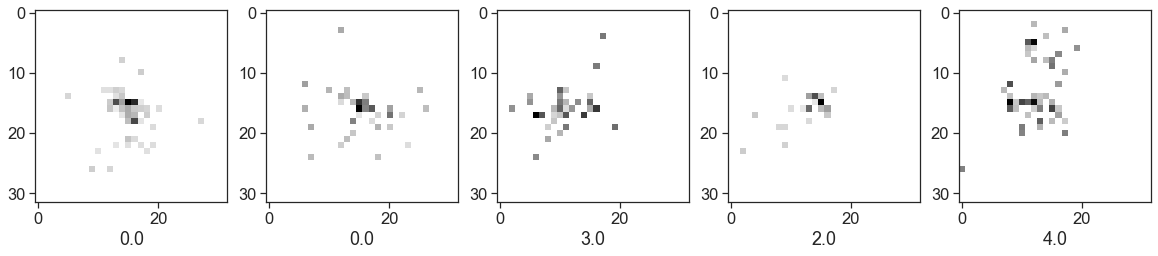

In [106]:
# Visualize some test data
import random

M = raw_test_features.shape[0]
indices = random.sample(range(M), 5)

plt.figure(figsize=(20, 20))

for i, idx in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(raw_test_features[idx], cmap="Greys")
    plt.xlabel(test_targets[idx])

In [107]:
# Perform standard scaling on the training and testing features
# After scaling, make sure you reshape the training features back to (10000, 28, 28) and testing features to (1000, 28, 28)
# since CNNs take 2D tensors as inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def scale_features(features):
    flattened = features.reshape(features.shape[0], -1)
    scaled = scaler.fit_transform(flattened)
    return scaled.reshape(features.shape)

train_features = scale_features(raw_train_features)
test_features = scale_features(raw_test_features)

In [108]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set
validation_features = train_features[:500]
validation_targets = train_targets[:500]

# Take the remaining 9000 training features and targets as training set
train_features = train_features[500:]
train_targets = train_targets[500:]

In [109]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs
train_features = np.expand_dims(train_features, 1)
validation_features = np.expand_dims(validation_features, 1)
test_features = np.expand_dims(test_features, 1)

## Define Model

In [110]:
class CNNModel(torch.nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        # Let's use LeNet: https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg

        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool1_bn = torch.nn.BatchNorm2d(12)

        self.cnn2 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool2_bn = torch.nn.BatchNorm2d(24)

        self.fc1 = torch.nn.Linear(24 * 8 * 8, 10)
        

    def forward(self, x):
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final output
        # since it's incorporated within the loss function

        relu = torch.nn.functional.relu

        conv1_out = relu(self.cnn1(x))
        pool1_out = self.maxpool1(conv1_out)
        pool1_out_bn = self.maxpool1_bn(pool1_out)

        conv2_out = relu(self.cnn2(pool1_out_bn))
        pool2_out = self.maxpool2(conv2_out)
        pool2_out_bn = self.maxpool2_bn(pool2_out)

        fcn_input = pool2_out.view(pool2_out_bn.size(0), -1)
        fc1_out = self.fc1(fcn_input)

        return fc1_out

## Select Hyperparameters

In [168]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 1e-3
epochs = 10
batchsize = 10

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    model.to(0)

import gc
gc.collect()
torch.cuda.empty_cache()

## Identify Tracked Values

In [169]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
train_accuracy_list = []
validation_accuracy_list = []

## Train Model

In [170]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient

torch_validate_features = torch.from_numpy(validation_features).float().to(0)
torch_validate_targets = torch.from_numpy(validation_targets).long().to(0)

def to_torch_float(arr):
    return torch.from_numpy(arr).float().to(0)
    
def to_torch_long(arr):
    return torch.from_numpy(arr).long().to(0)

train_batched_features = np.array_split(train_features, batchsize)
train_batched_targets = np.array_split(train_targets, batchsize)

batch_split_num = len(train_batched_features)

# Training Loop ---------------------------------------------------------------------------------------
for epoch in tqdm.trange(epochs, ncols=80):    
    for b in range(batch_split_num):
        optimizer.zero_grad()

        outputs = model(to_torch_float(train_batched_features[b]))
        loss = loss_func(outputs, to_torch_long(train_batched_targets[b]))
        loss.backward() # Compute gradients
        
        train_loss_list.append(loss.item())

        optimizer.step() # Update parameters
    

    # Compute Validation Accuracy
    # ----------------------------------------------------------------------

    with torch.no_grad():
        predictions = torch.argmax(model(torch_validate_features), dim=1)
        correct = predictions == torch_validate_targets
        accuracy = torch.mean(correct.type(torch.FloatTensor))
        validation_accuracy_list.append(accuracy.item() * 100)

100%|███████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


## Visualize & Evaluate Model

In [171]:
# Seaborn for prettier plot
import seaborn as sns
sns.set(style = 'ticks', font_scale = 1.5)

Text(0.5, 0, 'iterations')

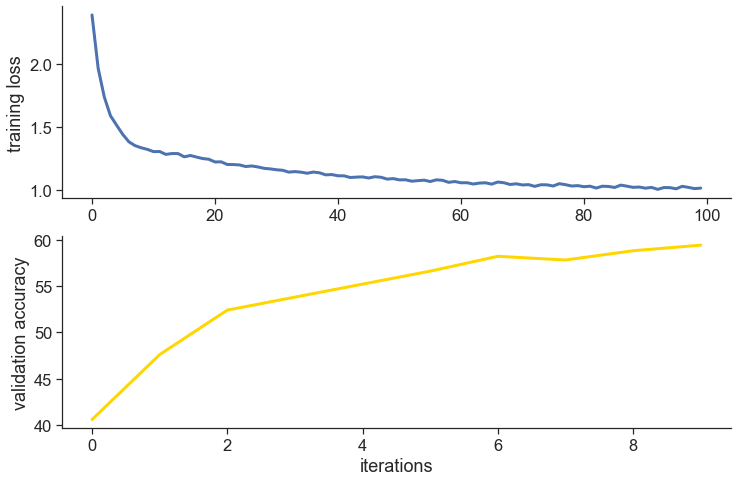

In [172]:
# Visualize training loss

plt.figure(figsize = (12, 12))

plt.subplot(3, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
sns.despine()

""" plt.subplot(3, 1, 2)
plt.plot(train_accuracy_list, linewidth = 3, color = 'red')
plt.ylabel("training accuracy")
sns.despine() """

plt.subplot(3, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()
plt.xlabel("iterations")

In [173]:
print(f"Validation accuracy: {round(validation_accuracy_list[-1], 3)}%")

Validation accuracy: 59.4%


In [176]:
# Compute the testing accuracy 
torch_test_inputs = torch.from_numpy(test_features).float().to(0)
torch_test_targets = torch.from_numpy(test_targets).long().to(0)

with torch.no_grad():
    test_predictions = torch.argmax(model(torch_test_inputs), dim=1)
    correct = (test_predictions == torch_test_targets).type(torch.FloatTensor)
    accuracy = torch.mean(correct.type(torch.FloatTensor)).item() * 100

print(f"Testing accuracy: {round(accuracy, 3)}%")

Testing accuracy: 59.6%


: 

In [175]:
labels = [
    "Gluon",
    "Light quark",
    "W boson",
    "Z boson",
    "Top quark"
]

for i in range(len(labels)):
    indices = np.where(test_targets == i)[0]
    predictions = test_predictions[indices].cpu().numpy()
    targets = test_targets[indices]
    accuracy = np.mean((predictions == targets).astype(float))

    print(f"Accuracy of {labels[i]}:".ljust(25), f"{round(accuracy * 100, 1)}%")

Accuracy of Gluon:        66.7%
Accuracy of Light quark:  56.3%
Accuracy of W boson:      48.7%
Accuracy of Z boson:      52.8%
Accuracy of Top quark:    70.3%
